# Lab 6: Light Fields

Inspired on the HW6 of the EECS 395/495: Introduction to Computational Photography (Northwestern University)

In this homework, you will capture a light field by waving your cell phone camera around. The goal of this homework is to synthesize an image that appears to be captured from a synthetic aperture that is much larger aperture than your cell phone camera [1]. The advantage of this technique is that captured images can have a significantly smaller depth of field, giving the look and feel of a much more expensive camera. The other advantage is that, because we are capturing a light field, we can digitally refocus the image. The disadvantage of this technique is that, because it relies on sequential image capture, it will only work for static scenes. The technique requires the image sequence to be registered, and the quality of the final photograph will be limited by how well the images can be registered. In this homework, we will use a simple auto-correlation based registration scheme.

In [1]:
#some magic to show the images inside the notebook
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import ndimage
import imageio 
import numpy as np
import subprocess
import matplotlib.pyplot as plt

# A hepler function for displaying images within the notebook.
# It displays an image, optionally applies zoom the image.
def show_image(img, zoom=1.5):
    dpi = 77
    plt.figure(figsize=(img.shape[0]*zoom/dpi,img.shape[0]*zoom/dpi))
    if len(img.shape) == 2:
        img = np.repeat(img[:,:,np.newaxis],3,2)        
    plt.imshow(img, interpolation='nearest')
    

# A hepler function for displaying images within the notebook.
# It may display multiple images side by side, optionally apply gamma transform, and zoom the image.
def show_images(imglist, zoom=1, needs_encoding=False):
    if type(imglist) is not list:
       imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 77 # pyplot default?
    plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        plt.subplot(1,n,i + 1)
        plt.tight_layout()    
        plt.axis('off')
        if len(img.shape) == 2:
           img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.imshow(img, interpolation='nearest')    
    

def saveHDR(filename, image):
    f = open(filename, "wb")
    f.write(str.encode("#?RADIANCE\n# Made with Python & Numpy\nFORMAT=32-bit_rle_rgbe\n\n"))
    f.write(str.encode("-Y {0} +X {1}\n".format(image.shape[0], image.shape[1])))
    
    brightest = np.maximum(np.maximum(image[...,0], image[...,1]), image[...,2])
    mantissa = np.zeros_like(brightest)
    exponent = np.zeros_like(brightest)
    np.frexp(brightest, mantissa, exponent)
    scaled_mantissa = mantissa * 256.0 / brightest
    rgbe = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    rgbe[...,0:3] = np.around(image[...,0:3] * scaled_mantissa[...,None])
    rgbe[...,3] = np.around(exponent + 128)
    
    rgbe.flatten().tofile(f)
    f.close()

def dcraw_meta(path):
    lines = subprocess.check_output(["dcraw", "-i", "-v", path]).decode("utf-8").splitlines()
    lines = [[x.strip() for x in line.split(":", 1)] for line in lines if ":" in line]
    lines = { x[0] : x[1] for x in lines }

    if "Aperture" in lines:
        lines["Aperture"] = float(lines["Aperture"].split("/")[1])

    if "ISO speed" in lines:
        lines["ISO speed"] = float(lines["ISO speed"])

    if "Shutter" in lines:
        shutter = lines["Shutter"].split()[0]
        shutter = shutter.split("/")
        lines["Shutter"] = float(shutter[0]) / float(shutter[1])

    return lines

def getExposureInSeconds(path):
    meta = dcraw_meta(path)
    result = meta["Aperture"] ** 2 / (meta["Shutter"] * meta["ISO speed"])
    return meta["Shutter"]

def make_frame(im, sizex, coords, sizey=0, bold = 1, color = 1):
    img = copy(im)
    if sizey==0:
        sizey=sizex
    (x,y)=coords
    if color:
        px = [255,0,0]
    else:
        px = 255
    img[y-sizey-bold:y-sizey+bold, x-sizex:x+sizex+1] = \
        [[px for b in range(x-sizex,x-sizex+1)] for a in range(y-sizey-bold,y-sizey+bold)]

    img[y+sizey-bold:y+sizey+bold, x-sizex:x+sizex+1] = \
        [[px for b in range(x-sizex,x-sizex+1)] for a in range(y+sizey-bold,y+sizey+bold)]

    img[y-sizey-bold:y+sizey+bold,x-sizex-bold:x-sizex+bold] = \
        [[px for b in range(x-sizex-bold,x-sizex+bold)] for a in range(y-sizey-bold,y+sizey+bold)]

    img[y-sizey-bold:y+sizey+bold,x+sizex-bold:x+sizex+bold] = \
        [[px for b in range(x+sizex-bold,x+sizex+bold)] for a in range(y-bold-sizey,y+bold+sizey)]
    return img


Populating the interactive namespace from numpy and matplotlib


## Task 1: Capture an unstructured light field (20 points)


You will capture a video as you wave your camera around in front of a static scene. Here are some guidelines.
 
1.    You need to avoid tilting and rotating the camera as much as possible. You should just shift the camera in a plane (see Figure 1). You may need to try this several times before you capture a good video.

2.    You may want to press the phone against a flat object to help guide the planar motion

3.    We might want to use a zig-zag motion In general, the more you cover the plane, the better your results in the next section will be.

![alt text](imgs/image1.png)

4.    Make sure your video is not too long. You should capture a few seconds of video.
5.    Capture a scene with a few objects at different depths one object with enough depth. See [Stanford LF repository](http://lightfield.stanford.edu/lfs.html) for examples. In the next section you will create narrow synthetic aperture images that are focused on these objects
6.    Make sure that all of the objects in the scene are in focus. As long as objects are about a meter in size and 1-2 meters away, they will more or less be in focus.


## Task 2: Process video and extract frames (30 points)

Once you have captured a video, we need to register frames of captured video and generate our LF. 

You should be able to use imageio to load a video and convert it to frames. Have a look to [Examples](http://imageio.readthedocs.io/en/latest/examples.html). The idea is to select a number of frames to create a LF. Anything between 7x7 and 11x11 will be fine. 

When you save the frames, you might want to reduce the resolution too, and maybe crop to the area of interest, to make it easier to handle later. Arround 400 pixels will be enough. 

Here an example of an actual lightfield capture with Lytro (GIL, University of Zaragoza)

![alt text](imgs/frog.jpg)

Note that if you recorded about 1 minute of video, this means 1800 frames, which is not nice to select frames manually!! So you might want to look at your video before in VLC and pre-select the images before saving them. 

YOU DON'T NEED TO CREATE A SINGLE IMAGE FOR YOUR LF


81


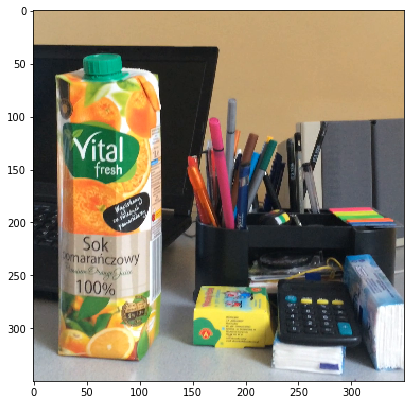

In [7]:

reader = imageio.get_reader('iPhone/IMG_8189.MOV')

data=[]
data_full = []
for im in reader:
    im1 = im[0::3,0::3]
    data_full += [im1]
    data+=[im1[200:550,0:350]]
data=data[:81]
# obraz = data[20]
show_image(data[21])
# print obraz, obraz[0::2], obraz[0::2,0::2]
# show_image(obraz[0::3,0::3])
print(len(data))

In [8]:
size=9
gray_data = []
for x in range(0, len(data)):
#     imageio.imwrite("data/{0}-{1}.png".format(x//9+1,x%9+1), data[x])
    r, g, b = data[x][:,:,0], data[x][:,:,1], data[x][:,:,2]
    gray = (0.2989 * r + 0.5870 * g + 0.1140 * b)/255.
    gray_data += [gray]
    gray2 = [make_frame(gray_data[0],sizex = 8,coords = (150,70), bold = 1, color = 0)]
#     imageio.imwrite("gray_data/{0}-{1}.png".format(x//9+1,x%9+1), gray)
#     imageio.imwrite("test/{0}-{1}.png".format(x//9+1,x%9+1), gray2)
    


In [5]:
size=9
big_frame = (80,220,50,190)

## Task 3: Register the frames of video using template matching (70 points)

Registration should be performed on grayscale video frames. You will use a simple template-matching scheme. Here is what you need to do:
 
1.    Convert each frame of your video to grayscale

![alt text](imgs/image2.png)

2.    The red box in the figure shows the template that was used for registration. You will need to select a similar template from the first frame of your video. You will then search for a match to this template in successive frames. The location of the match will tell you how many pixels your camera has shifted. Choose a size for this template (i.e. 16x16 pixels). You may need to adjust this to improve your results.

![alt text](imgs/image3.png)

4.    You only need to search for a template match within a window of your target frame. The window should be centered on the location of the template in the first frame. 


5. So you need to compare the template with all possible possitions within the window search and find the one that is most similar. You can use Normalized Cross Correlation, or Sum of Square Distances, or other metric of your choice. This should give you the estimated position (translation) of each image with respect to the reference frame. Some thing like this:

![alt text](imgs/image4.jpg)


In [5]:
template = gray_data[0][76:90,161:175]
# corr_t = signal.correlate2d(template, template)
# print template.shape
# show_image(template)
lista=[]
for i in range(len(gray_data)):
    print i
    img = gray_data[i][big_frame[2]:big_frame[3],big_frame[0]:big_frame[1]]
    cs = np.sum((img[0:0+14,0:0+14] - template)**2)
    cx=0
    cy=0
    for x in range(140-14):
        for y in range(140-14):
            suma = np.sum((img[y:y+14,x:x+14] - template)**2)
            if suma < cs:
                cx = x
                cy = y
                cs = suma
#     show_image(img[cy:cy+14,cx:cx+14])
    lista+=[[cx,cy,cs]]
# print lista
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [7]:
import pickle
with open("dump", 'wb') as f:
    pickle.dump(lista, f)

In [3]:
import pickle

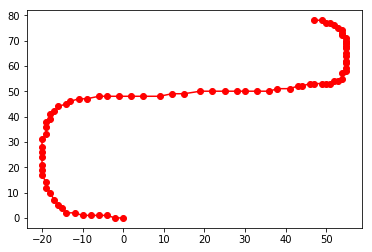

In [10]:
n_list= np.array(lista)
n_list = n_list[:,:2] + np.array([big_frame[0]-161,big_frame[2]-76]  )
plt.plot(n_list[:,0]*-1, n_list[:,1], "-or")

## Task 3: Create a synthetic aperture photograph (30 points)
 
Once you have calculated the pixel shift, you can generate a synthetic aperture photograph simply by shifting the images of each frame of video in the opposite direction and then summing up the result. This will be equivalent to focus on the plane where the template used for alignment is, with an apperture of the size of the max displacement. 


In [9]:
with open("dump", 'rb') as f:
    my_list = pickle.load(f)

n_list= np.array(my_list)
n_list = n_list[:,:2] + np.array([big_frame[0]-161,big_frame[2]-76]  )   

from scipy.ndimage.interpolation import shift

image = shift(data_full[0], (0,0,0), cval=0)
# show_imag(a)
# print n_list[0]
shift_frames = [image]
for i in range(1,len( n_list)):
    [x,y]=n_list[i]
    temp_img = shift(data_full[i], (-y,-x,0), cval=0)
#     image= (image+temp_img)//2
    shift_frames+=[temp_img]
    print i
#     show_image(temp_img)
    
    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [38]:
for x in range(0, len(shift_frames)):
    imageio.imwrite("test/{0}-{1}.png".format(x//9+1,x%9+1), shift_frames[x])

In [11]:
full_shift=[]
for x in shift_frames:
    full_shift += [x[200:550,0:350]]


In [18]:
writer = imageio.get_writer('stabilized_s.mp4', fps=30)

for im in full_shift:
    writer.append_data(im)
writer.close()

In [19]:
writer = imageio.get_writer('stabilized_f.mp4', fps=30)

for im in shift_frames:
    writer.append_data(im)
writer.close()

[[[203 209 219]
  [203 209 219]
  [203 208 219]
  ..., 
  [110 135 171]
  [112 137 173]
  [114 139 174]]

 [[206 211 221]
  [206 212 221]
  [206 211 221]
  ..., 
  [110 135 171]
  [112 137 172]
  [114 139 174]]

 [[209 214 222]
  [209 214 222]
  [209 213 222]
  ..., 
  [109 135 171]
  [112 137 172]
  [114 139 174]]

 ..., 
 [[175 172 169]
  [175 172 169]
  [173 170 167]
  ..., 
  [125 120 113]
  [127 123 115]
  [129 125 117]]

 [[175 171 169]
  [175 172 169]
  [173 169 167]
  ..., 
  [124 119 112]
  [127 123 115]
  [129 124 116]]

 [[175 171 169]
  [175 172 169]
  [173 169 167]
  ..., 
  [123 118 111]
  [126 121 113]
  [128 123 116]]]


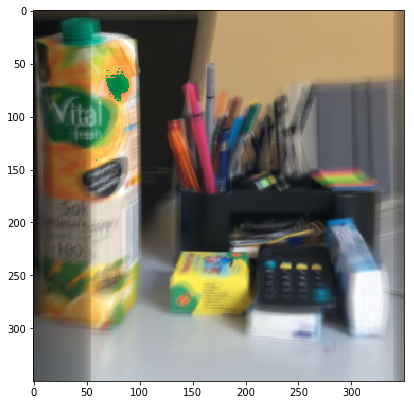

In [35]:
sum_of_images = 0
# print sum_of_images.shape
for img in full_shift:
#     print "\nimg:\n\n\n", img
    sum_of_images += np.array(img).astype(int)
#     print "\n\n\nsum: \n", sum_of_images
    
# sum_of_images = sum_of_images - np.array(full_shift[0])
sum_of_images = sum_of_images // len(full_shift)
print 255 - sum_of_images.astype('H')

show_image(255-sum_of_images.astype('H'))

## Task 4: Focal stack video/GIF (50 points)

Create images with focus at different distances using your light field. You can put them together in a short video/GIF (see imageio examples). 

You can do this first in the sample light field (frog.jpg). Use the center view. You simple have to shift away from the center, or towards the center by a distance proportional to the depth. Since your images are not uniformly sampled (as in the example light field (figure 2). 

The distance between views is the same, so the relationship between the displacements should be proportional. You can do this for a couple of apertures, 9 and 5 (for example). This will mean to average 17 or 5 pictures in each axis respectively.

Do the same for your light field. Now, since the sampling is not uniform, the distances that you need to shift the images is proportional to the displacement of a particular frame how far they are from the center.

Now, if you want to change the aperture, you need to change the images you use depending of the distance to the focus point. 

## Extra: Extend the task 4 so you can also change the view point of the light field. 

## Extra: Extend the task 4 so you focus on different objects (this will depend on the depth of the object). 